In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bias_detection_model.pt to bias_detection_model.pt


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import numpy as np
from tqdm import tqdm
from google.colab import files

# STEP 1: Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 2: Load the saved model and thresholds
checkpoint = torch.load('bias_detection_model.pt', weights_only=False)
bias_columns = checkpoint['bias_columns']
optimal_thresholds = checkpoint['optimal_thresholds']

expected_bias_columns = ['Final_Gender_Bias', 'Final_Religion_Bias', 'Final_Age_Bias', 'Final_Disability_Bias', 'Final_Sexuality_Bias']
if bias_columns != expected_bias_columns:
    raise ValueError(f"Model bias columns {bias_columns} do not match dataset bias columns {expected_bias_columns}")

# Initialize model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5, problem_type="multi_label_classification")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# STEP 3: Load the dataset
uploaded = files.upload()
df = pd.read_csv('sentence_by_sentence_Gemini.csv')

# Ensure 'Sentence_Text' column exists
if 'Sentence_Text' not in df.columns:
    raise ValueError("Dataset must contain a 'Sentence_Text' column")

# Handle potential missing or invalid text entries
df['Sentence_Text'] = df['Sentence_Text'].fillna('').astype(str)
texts = df['Sentence_Text'].tolist()

# STEP 4: Define dataset class for prediction
class PredictionDataset(Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=256)

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

# Create dataset and dataloader
dataset = PredictionDataset(texts)
dataloader = DataLoader(dataset, batch_size=8)

# STEP 5: Run predictions
all_preds = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(dataloader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        probs = torch.sigmoid(outputs).cpu().numpy()

        # Apply optimal thresholds
        preds = np.zeros_like(probs)
        for i in range(len(bias_columns)):
            preds[:, i] = (probs[:, i] >= optimal_thresholds[i]).astype(int)

        all_preds.extend(preds)
        all_probs.extend(probs)

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# STEP 6: Add predictions and probabilities to the DataFrame
for i, bias_type in enumerate(bias_columns):
    df[f'Predicted_{bias_type}'] = all_preds[:, i]
    df[f'Probability_{bias_type}'] = np.round(all_probs[:, i], 3)  # Round probabilities to 3 decimal places

# STEP 7: Define columns to keep
columns_to_keep = [
    'ReportID', 'Company', 'Prompt_Type', 'SentenceNum', 'Sentence_Text',
    'Predicted_Final_Gender_Bias', 'Probability_Final_Gender_Bias',
    'Predicted_Final_Religion_Bias', 'Probability_Final_Religion_Bias',
    'Predicted_Final_Age_Bias', 'Probability_Final_Age_Bias',
    'Predicted_Final_Disability_Bias', 'Probability_Final_Disability_Bias',
    'Predicted_Final_Sexuality_Bias', 'Probability_Final_Sexuality_Bias'
]

# Remove unnecessary columns and keep only specified ones
df = df[columns_to_keep]

# STEP 8: Save the results
output_file = 'Predictions_Cleaned.csv'
df.to_csv(output_file, index=False)
print(f"Predictions saved to '{output_file}'")

# Download the results
files.download(output_file)

# STEP 9: Summarize predictions
print("\nPrediction summary:")
for i, bias_type in enumerate(bias_columns):
    positive_count = np.sum(all_preds[:, i])
    print(f"{bias_type}: {positive_count} positive predictions out of {len(df)}")




Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Saving sentence_by_sentence_Gemini.csv to sentence_by_sentence_Gemini (5).csv


Predicting: 100%|██████████| 1358/1358 [02:18<00:00,  9.83it/s]


Predictions saved to 'Predictions_Cleaned.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Prediction summary:
Final_Gender_Bias: 681.0 positive predictions out of 10862
Final_Religion_Bias: 675.0 positive predictions out of 10862
Final_Age_Bias: 549.0 positive predictions out of 10862
Final_Disability_Bias: 829.0 positive predictions out of 10862
Final_Sexuality_Bias: 111.0 positive predictions out of 10862


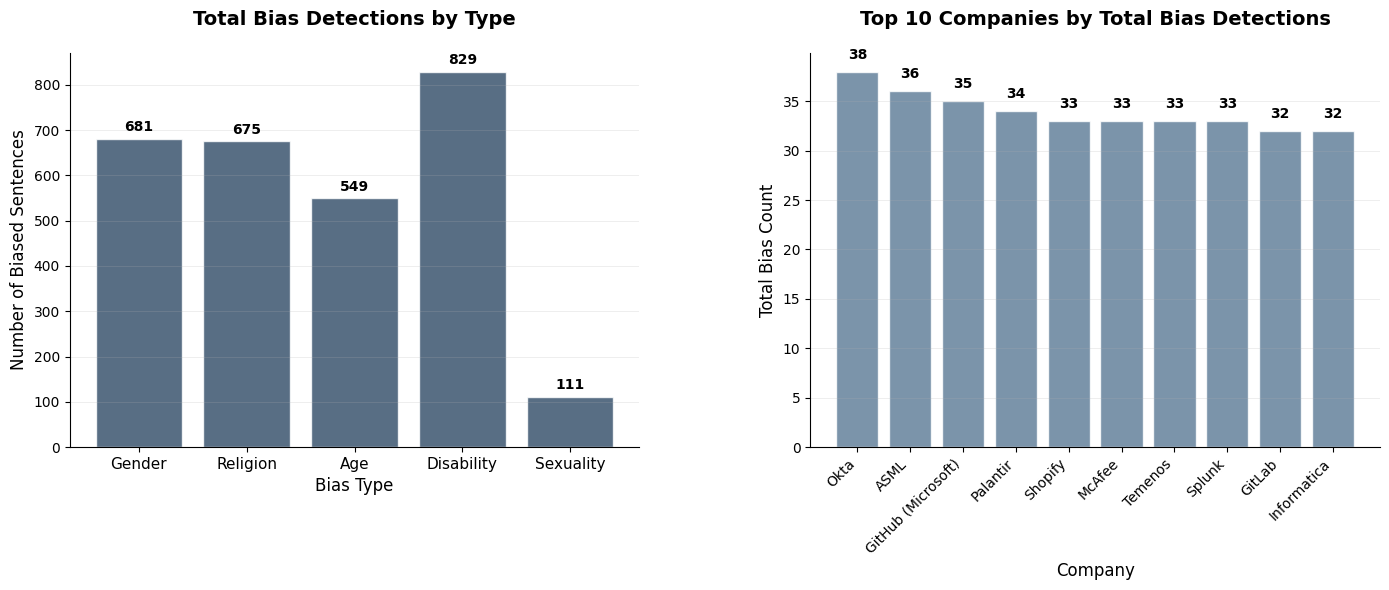


SUMMARY STATISTICS
Total sentences analyzed: 10,862
Total biased sentences: 2,845.0
Overall bias rate: 26.19%

Bias breakdown:
  Gender: 681.0 (6.3%)
  Religion: 675.0 (6.2%)
  Age: 549.0 (5.1%)
  Disability: 829.0 (7.6%)
  Sexuality: 111.0 (1.0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

# Load predictions data
df = pd.read_csv('Predictions_Cleaned.csv')

# Define bias types for cleaner labels
bias_types = ['Gender', 'Religion', 'Age', 'Disability', 'Sexuality']
bias_columns = ['Predicted_Final_Gender_Bias', 'Predicted_Final_Religion_Bias',
                'Predicted_Final_Age_Bias', 'Predicted_Final_Disability_Bias',
                'Predicted_Final_Sexuality_Bias']

# Set up professional plot style
plt.style.use('default')
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Professional color scheme - muted blues and grays
color1 = '#2E4A66'  # Dark blue
color2 = '#5A7A95'  # Medium blue

# 1. Overall Bias Detection Summary
bias_counts = [df[col].sum() for col in bias_columns]

bars = axes[0].bar(bias_types, bias_counts, color=color1, alpha=0.8, edgecolor='white', linewidth=1)
axes[0].set_title('Total Bias Detections by Type', fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Number of Biased Sentences', fontsize=12)
axes[0].set_xlabel('Bias Type', fontsize=12)

# Add value labels on bars
for bar, count in zip(bars, bias_counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(int(count)), ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[0].tick_params(axis='x', rotation=0, labelsize=11)
axes[0].tick_params(axis='y', labelsize=10)
axes[0].grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# 2. Top 10 Companies by Total Bias
company_bias = df.groupby('Company')[bias_columns].sum().sum(axis=1).sort_values(ascending=False).head(10)
bars = axes[1].bar(range(len(company_bias)), company_bias.values, color=color2, alpha=0.8, edgecolor='white', linewidth=1)
axes[1].set_title('Top 10 Companies by Total Bias Detections', fontsize=14, fontweight='bold', pad=20)
axes[1].set_ylabel('Total Bias Count', fontsize=12)
axes[1].set_xlabel('Company', fontsize=12)
axes[1].set_xticks(range(len(company_bias)))
axes[1].set_xticklabels(company_bias.index, rotation=45, ha='right', fontsize=10)

# Add value labels
for bar, count in zip(bars, company_bias.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(int(count)), ha='center', va='bottom', fontweight='bold', fontsize=10)

axes[1].tick_params(axis='y', labelsize=10)
axes[1].grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)


plt.tight_layout()
plt.subplots_adjust(wspace=0.3)

# Save image
plt.savefig('bias_detection_summary.png', dpi=300, bbox_inches='tight',
            facecolor='white', edgecolor='none')
plt.show()

# Print summary statistics
total_sentences = len(df)
total_biased = sum(bias_counts)
print(f"\nSUMMARY STATISTICS")
print(f"{'='*40}")
print(f"Total sentences analyzed: {total_sentences:,}")
print(f"Total biased sentences: {total_biased:,}")
print(f"Overall bias rate: {(total_biased/total_sentences)*100:.2f}%")
print(f"\nBias breakdown:")
for bias_type, count in zip(bias_types, bias_counts):
    percentage = (count/total_sentences)*100
    print(f"  {bias_type}: {count:,} ({percentage:.1f}%)")

files.download('bias_detection_summary.png')